In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import CubicSpline
import flygym.mujoco
import flygym.mujoco.preprogrammed
from tqdm import trange
from pathlib import Path

from flygym.mujoco.arena import Tethered


output_path = Path("./outputs")
output_path.mkdir(exist_ok=True)

In [2]:
def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_frequencies : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amplitudes : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_magnitudes += dr_dt * self.timestep

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators."""
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = (
                self.random_state.random(self.num_cpgs) * self.intrinsic_amps
            )
        else:
            self.curr_magnitudes = init_magnitudes

In [3]:
# Loading the data
single_step_directory = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/single_step_datasets")
single_steps_paths = sorted(list(single_step_directory.glob("*.pkl")))
single_steps_path = (single_steps_paths)[4]
print(f"Loading {single_steps_path}...")

with open(single_steps_path, "rb") as f:
    single_steps_data = pickle.load(f)
preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]
print(
    f"Preprogrammed steps have a length of {preprogrammed_steps_length} steps "
    f"at dt={preprogrammed_steps_timestep}s."
)

Loading /Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/single_step_datasets/RF_0stance_RM_0stance_RH_0swing.pkl...
Preprogrammed steps have a length of 45 steps at dt=0.001s.


In [4]:
#Check that the data is consistent
for k, v in single_steps_data.items():
    if k.startswith("joint_"):
        assert len(v) == preprogrammed_steps_length
        #assert v[0] == v[-1]

    legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]
dofs_per_leg = [
    "Coxa",
    "Coxa_roll",
    "Coxa_yaw",
    "Femur",
    "Femur_roll",
    "Tibia",
    "Tarsus1",
]

# Interpolate the data
phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
psi_funcs = {}
for leg in legs:
    joint_angles = np.array(
        [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
    )
    
    psi_funcs[leg] = CubicSpline(phase_grid, joint_angles, axis=1, bc_type="periodic")

    theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

joint_angles_by_leg = {}
for leg, psi_func in psi_funcs.items():
    joint_angles_by_leg[leg] = psi_func(theta_ts)

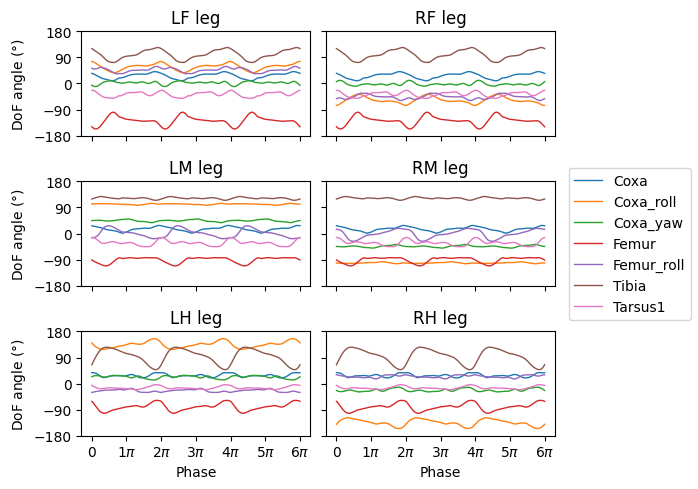

In [5]:
# Plot the joint angles
fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        psi_func = psi_funcs[leg]
        joint_angles = np.rad2deg(joint_angles_by_leg[leg])
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, joint_angles[i_dof, :], linewidth=1, label=legend)
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else f"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig("./outputs/three_steps.png")


In [6]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 100

tmstp = 1e-4

cpg_network = CPGNetwork(
    timestep=tmstp,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

In [7]:
swing_start = np.empty(6)
swing_end = np.empty(6)
start_type = [[] for _ in range(6)]
for i, leg in enumerate(legs):
    swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
    swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_start *= 2 * np.pi
swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_end *= 2 * np.pi

# have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
psi_rest_phases = np.ones_like(swing_start)
for i, leg in enumerate(legs):
    psi_rest_phases[i] = (swing_end[i] + 2*np.pi) / 2
    

In [21]:
run_time = 1
cam_name = "Animat/camera_bottom"
kp = 50.0
stifness = 10.0
damping = 10.0

sim_params = flygym.mujoco.Parameters(
    timestep=tmstp, render_mode="saved", render_playspeed=0.1, draw_contacts=False, render_camera=cam_name, actuator_kp=kp, tarsus_damping=damping, tarsus_stiffness=stifness
)
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    xml = "mjcf_ikpy_model",
    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
    control="position",
    arena=Tethered(),
)

joint_obs = []
fly_orient = []

obs, info = nmf.reset()

# set all not leg geoms to be transparent
leg_pref = [side+seg for side in "LR" for seg in "FMH"]
for geom in nmf.model.find_all("geom"):
    if not any([geom.name.startswith(pref) for pref in leg_pref]):
        nmf.physics.named.model.geom_rgba[f"Animat/{geom.name}"] = [0.5, 0.5, 0.5, 0]

# stabilise the flys
joint_obs.append(obs["joints"].copy())

joint_angles_input = []

phases = [[] for _ in legs]
magnitudes = [[] for _ in legs]

for k in trange(int(run_time / sim_params.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):
        phases[i].append(cpg_network.curr_phases[i])
        magnitudes[i].append(cpg_network.curr_magnitudes[i])

        #phi_base_phase should be in the middle of the stance phase: in between swing_end and swing_start
        psi = psi_funcs[leg](cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]

        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    action = {"joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints])}
    joint_angles_input.append(action["joints"])
    obs, reward, terminated, truncated, info = nmf.step(action)
    joint_obs.append(obs["joints"].copy())
    fly_orient.append(obs["fly"][2].copy())

    nmf.render()

cam_loc = cam_name.split("_")[-1]
nmf.save_video(f"./videos/cpg_controller_cam{cam_loc}_kp{kp}_tmstp{tmstp}_tether.mp4", stabilization_time=0)
#nmf.save_video(f"./videos/rest_2pi.mp4", stabilization_time=0)


100%|██████████| 10000/10000 [00:08<00:00, 1202.82it/s]


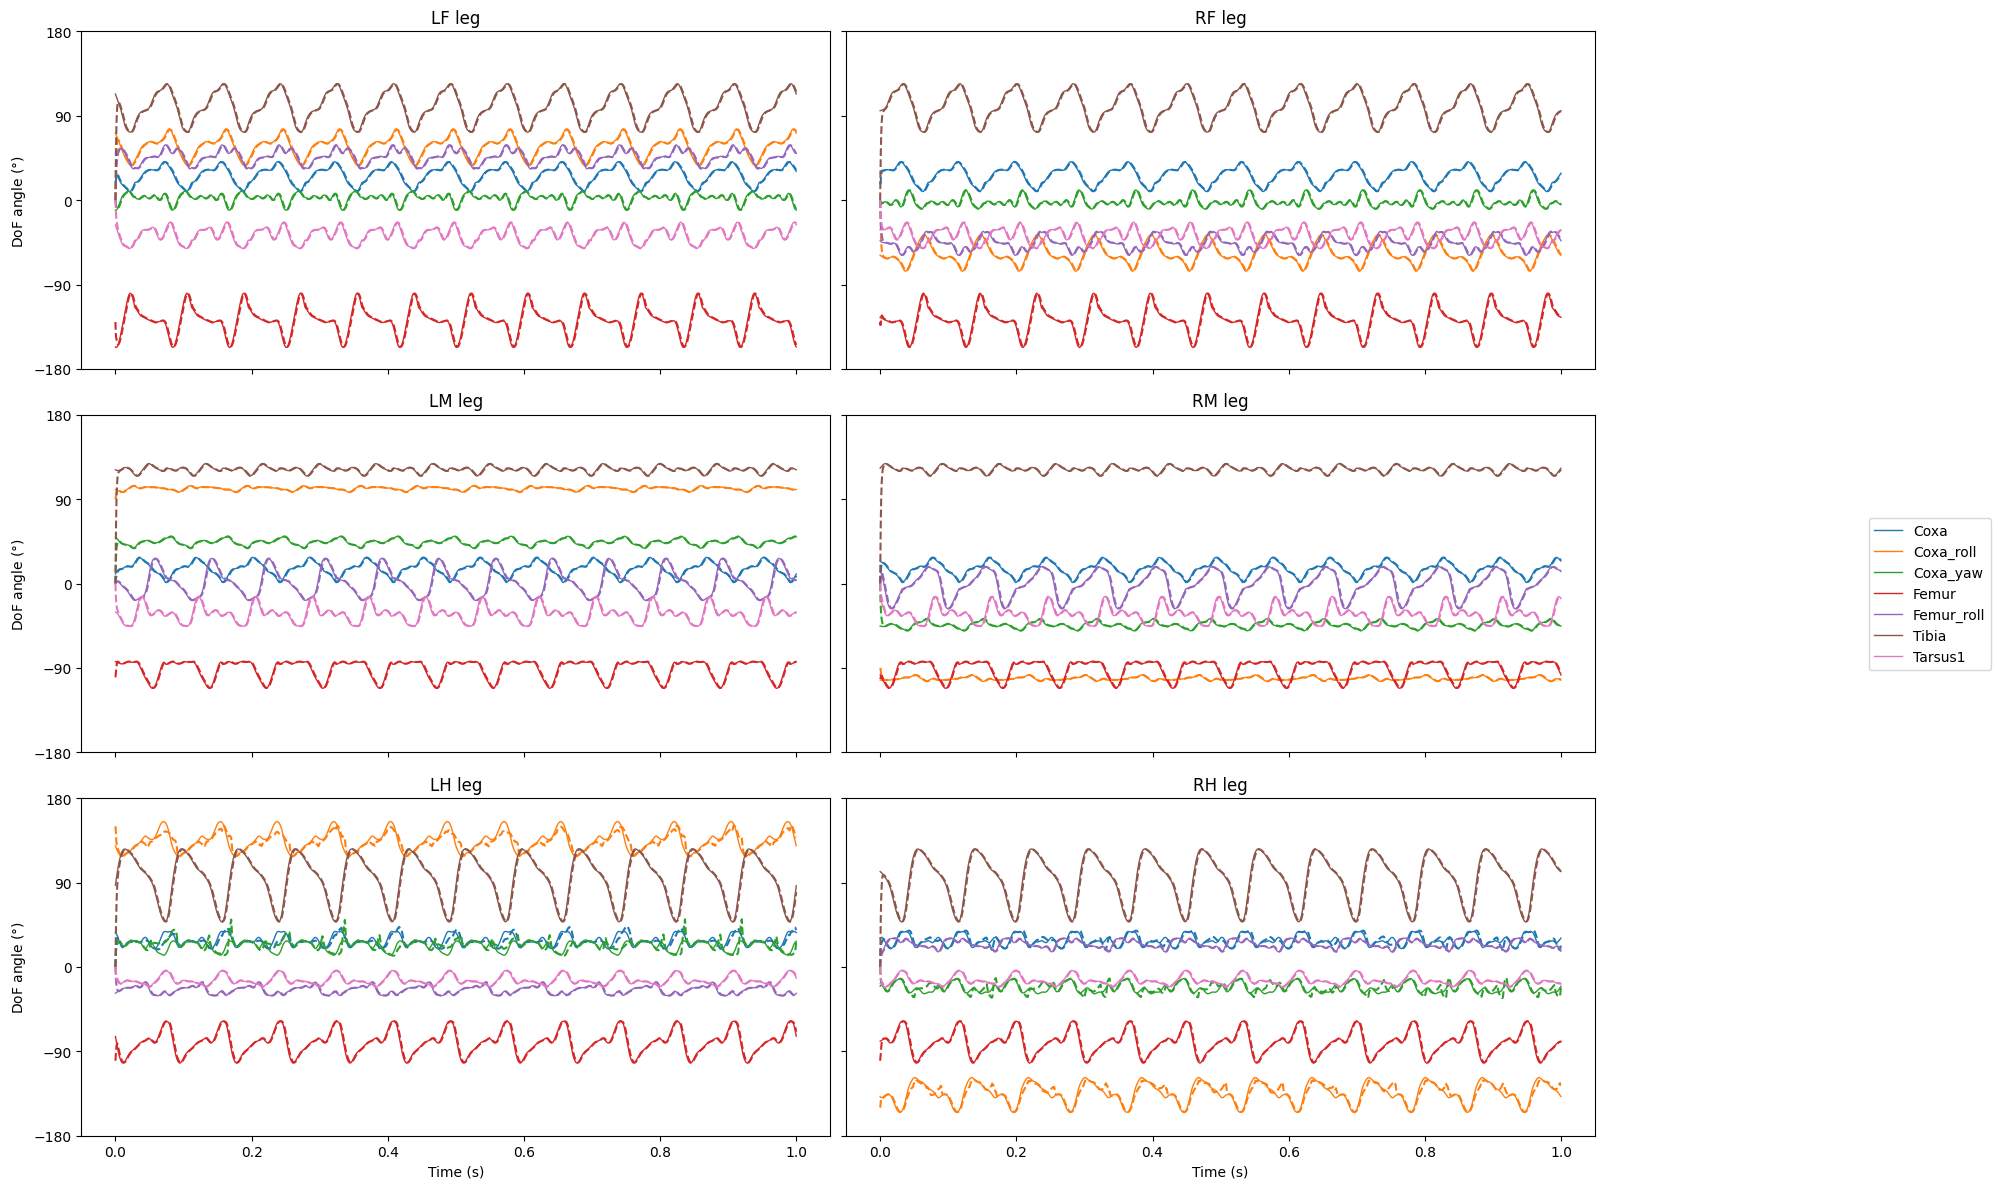

In [22]:
joint_angles_obs = np.array(joint_obs)[:, 0, :]
joint_angles_input = np.array(joint_angles_input)
time = np.arange(0, run_time, sim_params.timestep)
colors = plt.cm.tab10.colors

# Plot the joint angles
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            joint_index = nmf.actuated_joints.index(f"joint_{side}{pos}{dof_name}")
            ax.plot(time, np.rad2deg(joint_angles_input[:, joint_index]), linewidth=1, label=legend, color=colors[i_dof])
            ax.plot(time, np.rad2deg(joint_angles_obs[:-1, joint_index]), linestyle="--", color=colors[i_dof])
        if i_pos == 2:
            ax.set_xlabel("Time (s)")
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig("./outputs/three_steps_tehter.png")


Text(0, 0.5, 'Magnitude')

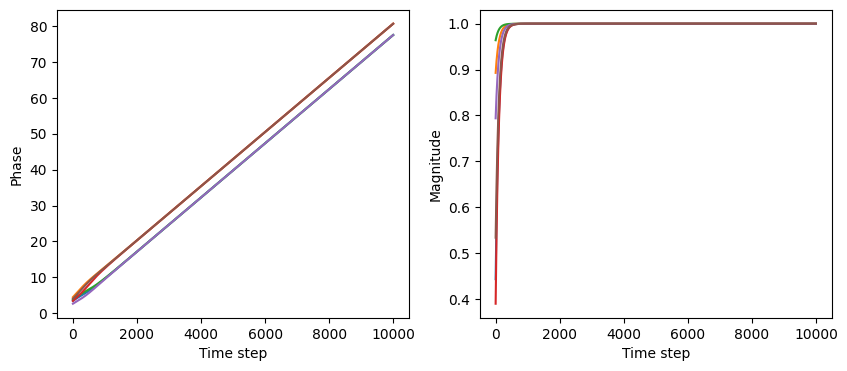

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)

ax[0].plot(np.transpose(phases))
ax[0].set_xlabel("Time step")
ax[0].set_ylabel("Phase")
ax[1].plot(np.transpose(magnitudes))
ax[1].set_xlabel("Time step")
ax[1].set_ylabel("Magnitude")